In [7]:
#%pip install torch torchvision matplotlib numpy lgbt scikit-learn ipywidgets

In [3]:
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.manifold import TSNE
import ipywidgets as widgets
from IPython.display import display

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def show_images(images, title):
    images = images.cpu().detach().numpy()
    plt.figure(figsize=(10, 2))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [10]:
def train_ae(model, train_loader, test_loader, epochs=20):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                outputs = model(data)
                loss = criterion(outputs, data)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
    
    return model

In [11]:
class FullyConnectedAE(nn.Module):
    def __init__(self):
        super(FullyConnectedAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()  # to probability
        )
    
    def forward(self, x):
        x = x.view(-1, 28*28)  # flatten
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 1, 28, 28)  # restore shape

Epoch 1/20, Train Loss: 0.0441, Test Loss: 0.0249
Epoch 2/20, Train Loss: 0.0231, Test Loss: 0.0218
Epoch 3/20, Train Loss: 0.0207, Test Loss: 0.0197
Epoch 4/20, Train Loss: 0.0191, Test Loss: 0.0185
Epoch 5/20, Train Loss: 0.0180, Test Loss: 0.0177
Epoch 6/20, Train Loss: 0.0171, Test Loss: 0.0168
Epoch 7/20, Train Loss: 0.0164, Test Loss: 0.0167
Epoch 8/20, Train Loss: 0.0158, Test Loss: 0.0156
Epoch 9/20, Train Loss: 0.0153, Test Loss: 0.0153
Epoch 10/20, Train Loss: 0.0149, Test Loss: 0.0149
Epoch 11/20, Train Loss: 0.0145, Test Loss: 0.0145
Epoch 12/20, Train Loss: 0.0142, Test Loss: 0.0142
Epoch 13/20, Train Loss: 0.0139, Test Loss: 0.0140
Epoch 14/20, Train Loss: 0.0136, Test Loss: 0.0137
Epoch 15/20, Train Loss: 0.0133, Test Loss: 0.0134
Epoch 16/20, Train Loss: 0.0130, Test Loss: 0.0131
Epoch 17/20, Train Loss: 0.0128, Test Loss: 0.0129
Epoch 18/20, Train Loss: 0.0126, Test Loss: 0.0127
Epoch 19/20, Train Loss: 0.0124, Test Loss: 0.0126
Epoch 20/20, Train Loss: 0.0122, Test Lo

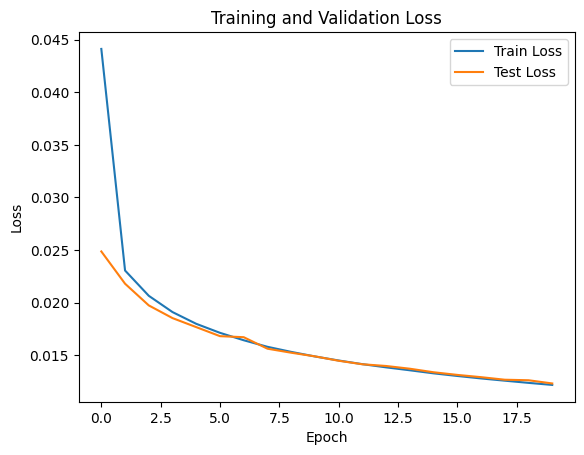

In [12]:
fc_ae = FullyConnectedAE()
fc_ae = train_ae(fc_ae, train_loader, test_loader)

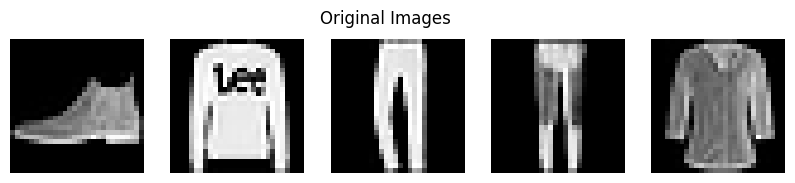

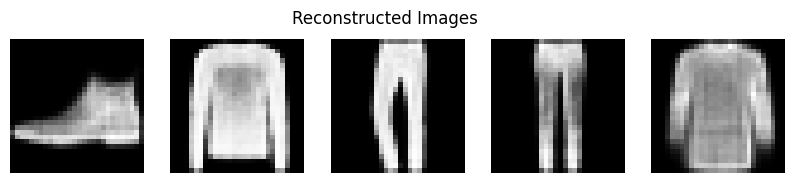

In [13]:
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    reconstructed = fc_ae(test_images)
    
show_images(test_images, 'Original Images')
show_images(reconstructed, 'Reconstructed Images')

In [14]:
torch.save(fc_ae, 'fc_autoencoder.pth')

In [15]:
def get_latent_representations(model, dataloader):
    model.eval()
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for data, label in dataloader:
            if isinstance(model, FullyConnectedAE):
                data = data.view(-1, 28*28)
                latent = model.encoder(data)
            else: 
                latent = model.encoder(data)
                latent = latent.view(latent.size(0), -1)
            latent_vectors.append(latent)
            labels.append(label)
    return torch.cat(latent_vectors), torch.cat(labels)

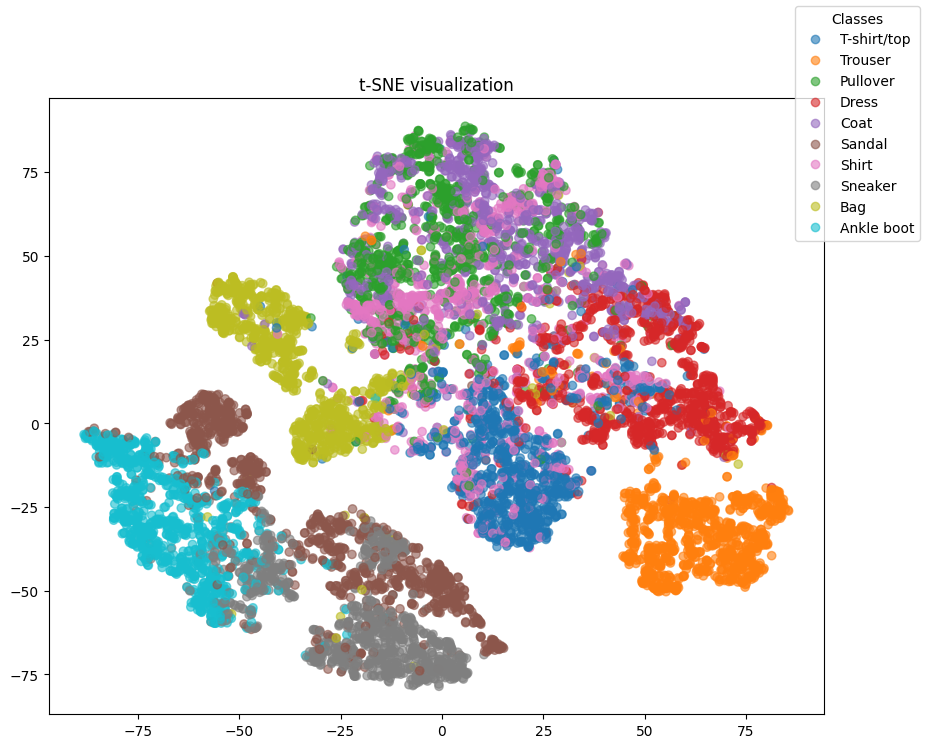

In [16]:
latent, labels = get_latent_representations(fc_ae, test_loader)

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent.cpu().numpy())

fig = plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    x=latent_2d[:, 0], 
    y=latent_2d[:, 1],
    c=labels.cpu().numpy(),  
    cmap='tab10',
    alpha=0.6
)
fig.legend(
    handles=scatter.legend_elements()[0],
    labels=classes,
    title="Classes"
)

plt.title('t-SNE visualization')
plt.show()

In [7]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 16x14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 32x7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),                     # 64x1x1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),              # 32x7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 16x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # 1x28x28
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/20, Train Loss: 0.0363, Test Loss: 0.0175
Epoch 2/20, Train Loss: 0.0151, Test Loss: 0.0134
Epoch 3/20, Train Loss: 0.0121, Test Loss: 0.0113
Epoch 4/20, Train Loss: 0.0104, Test Loss: 0.0100
Epoch 5/20, Train Loss: 0.0094, Test Loss: 0.0092
Epoch 6/20, Train Loss: 0.0087, Test Loss: 0.0085
Epoch 7/20, Train Loss: 0.0081, Test Loss: 0.0080
Epoch 8/20, Train Loss: 0.0077, Test Loss: 0.0076
Epoch 9/20, Train Loss: 0.0073, Test Loss: 0.0073
Epoch 10/20, Train Loss: 0.0071, Test Loss: 0.0072
Epoch 11/20, Train Loss: 0.0069, Test Loss: 0.0069
Epoch 12/20, Train Loss: 0.0067, Test Loss: 0.0068
Epoch 13/20, Train Loss: 0.0065, Test Loss: 0.0066
Epoch 14/20, Train Loss: 0.0064, Test Loss: 0.0065
Epoch 15/20, Train Loss: 0.0063, Test Loss: 0.0065
Epoch 16/20, Train Loss: 0.0062, Test Loss: 0.0064
Epoch 17/20, Train Loss: 0.0061, Test Loss: 0.0062
Epoch 18/20, Train Loss: 0.0060, Test Loss: 0.0062
Epoch 19/20, Train Loss: 0.0060, Test Loss: 0.0062
Epoch 20/20, Train Loss: 0.0059, Test Lo

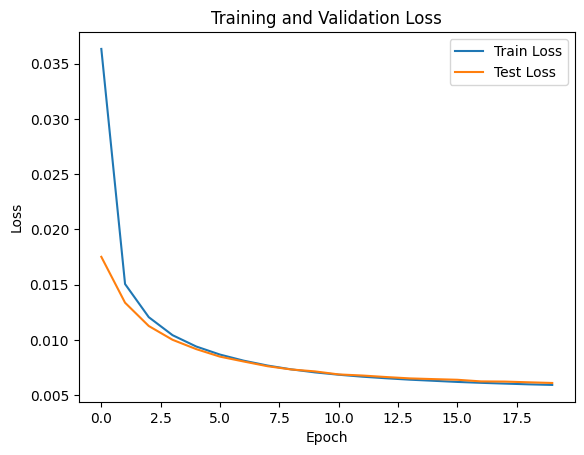

In [18]:
conv_ae = ConvAE()
conv_ae = train_ae(conv_ae, train_loader, test_loader)

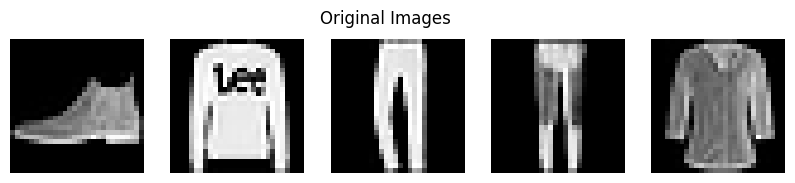

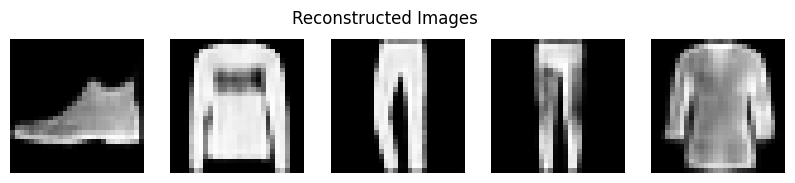

In [19]:
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    reconstructed = conv_ae(test_images)
    
show_images(test_images, 'Original Images')
show_images(reconstructed, 'Reconstructed Images')

In [20]:
torch.save(conv_ae, 'conv_autoencoder.pth')

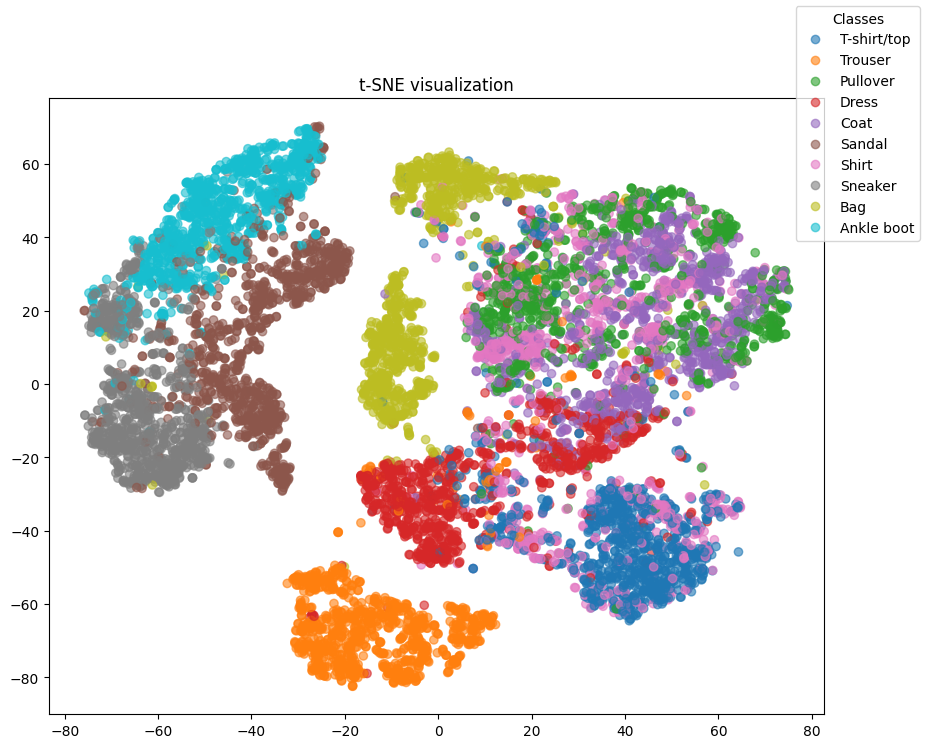

In [21]:
latent, labels = get_latent_representations(conv_ae, test_loader)

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent.cpu().numpy())

fig = plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    x=latent_2d[:, 0], 
    y=latent_2d[:, 1],
    c=labels.cpu().numpy(),  
    cmap='tab10',
    alpha=0.6
)
fig.legend(
    handles=scatter.legend_elements()[0],
    labels=classes,
    title="Classes"
)

plt.title('t-SNE visualization')
plt.show()

In [69]:
def interactive_decoder(model, latent_dim=10):
    sliders = []
    for i in range(latent_dim):
        sliders.append(widgets.FloatSlider(
            value=0, min=-5, max=5, step=0.1,
            description=f'Dim {i}', continuous_update=True
        ))
    
    output = widgets.Output()
    
    def update_image(**kwargs):
        latent_vector = torch.tensor([list(kwargs.values())], dtype=torch.float32)
        with torch.no_grad():
            if latent_dim < model.decoder[0].in_features:
                zeros = torch.zeros(1, model.decoder[0].in_features - latent_dim)
                latent_vector = torch.cat([latent_vector, zeros], dim=1)
            decoded = model.decoder(latent_vector).view(1, 1, 28, 28)
        
        with output:
            output.clear_output(wait=True)
            plt.imshow(decoded[0][0].cpu().numpy(), cmap='gray')
            plt.axis('off')
            plt.show()
    
    ui = widgets.VBox(sliders)
    widgets.interactive(update_image, **{slider.description: slider for slider in sliders})
    display(ui, output)

In [71]:
# Bag: tensor([[-0.5815,  1.3433, -4.7295,  4.9169, -3.8084,  1.0872,  4.2564, -0.4739, 
# -6.5072,  0.2354,  4.9120,  0.7913,  0.6069,  1.0183, -0.9036, -4.8580,
# 0.7147,  0.9834,  3.0541,  1.8986, -0.3537,  1.1716, -1.8450,  1.0723,
# 1.1313,  0.1562,  3.8053, -1.8767,  1.2592, -0.3425,  0.7553,  1.3512]],
# grad_fn=<AddmmBackward0>)

fc_ae = torch.load('fc_autoencoder.pth', weights_only=False)
fc_ae.eval()

interactive_decoder(fc_ae, latent_dim=32)

Output()

In [72]:
# import time

# for test_images, labels in test_loader:
#     print (labels)
#     show_images(test_images, 'Seeking for Bag')
#     time.sleep(2)

for test_images, labels in test_loader:
    if 8 in labels:
        for i in range (len(labels)):
            if labels[i] == 8:
                img = test_images[i]
                break
        break

feature = None

def get_features(module, inputs, output):
    global feature
    feature = output

fc_ae.encoder.register_forward_hook(get_features)

fc_ae.eval()
fc_ae(img)
coding = feature
coding


tensor([[-0.5815,  1.3433, -4.7295,  4.9169, -3.8084,  1.0872,  4.2564, -0.4739,
         -6.5072,  0.2354,  4.9120,  0.7913,  0.6069,  1.0183, -0.9036, -4.8580,
          0.7147,  0.9834,  3.0541,  1.8986, -0.3537,  1.1716, -1.8450,  1.0723,
          1.1313,  0.1562,  3.8053, -1.8767,  1.2592, -0.3425,  0.7553,  1.3512]],
       grad_fn=<AddmmBackward0>)

In [35]:
def get_parameters_size(param):
    size = 1
    for idx in range (len(param.shape)):
        size*=param.shape[idx]
    return (size)

In [ ]:
print('Parameter Name \t\tContents \t\t\tSize')
total_size = 0

for name, param in fc_ae.named_parameters():
    if len(param.shape)<=3: sym = '\t'
    else: sym = ''

    size = get_parameters_size(param)
    print(f'{name}  \t{param.shape} {sym}\t{size}')

    if 'weight' in name:
        total_size += size

print (f'Total number of weights: {total_size}')

Parameter Name 		Contents 			Size
encoder.0.weight  	torch.Size([256, 784]) 		200704
encoder.0.bias  	torch.Size([256]) 		256
encoder.2.weight  	torch.Size([128, 256]) 		32768
encoder.2.bias  	torch.Size([128]) 		128
encoder.4.weight  	torch.Size([64, 128]) 		8192
encoder.4.bias  	torch.Size([64]) 		64
encoder.6.weight  	torch.Size([32, 64]) 		2048
encoder.6.bias  	torch.Size([32]) 		32
decoder.0.weight  	torch.Size([64, 32]) 		2048
decoder.0.bias  	torch.Size([64]) 		64
decoder.2.weight  	torch.Size([128, 64]) 		8192
decoder.2.bias  	torch.Size([128]) 		128
decoder.4.weight  	torch.Size([256, 128]) 		32768
decoder.4.bias  	torch.Size([256]) 		256
decoder.6.weight  	torch.Size([784, 256]) 		200704
decoder.6.bias  	torch.Size([784]) 		784
Total number of weights: 487424


In [57]:
conv_ae = torch.load('conv_autoencoder.pth', weights_only=False)

total_size = 0

print('Parameter Name \t\tContents \t\t\tTotal Size')
for name, param in conv_ae.named_parameters():
    if len(param.shape)<=3: sym = '\t'
    else: sym = ''

    size = get_parameters_size(param)
    print(f'{name}  \t{param.shape} {sym}\t{size}')

    if 'weight' in name:
        total_size += size

print (f'Total number of weights: {total_size}')

Parameter Name 		Contents 			Total Size
encoder.0.weight  	torch.Size([16, 1, 3, 3]) 	144
encoder.0.bias  	torch.Size([16]) 		16
encoder.2.weight  	torch.Size([32, 16, 3, 3]) 	4608
encoder.2.bias  	torch.Size([32]) 		32
encoder.4.weight  	torch.Size([64, 32, 7, 7]) 	100352
encoder.4.bias  	torch.Size([64]) 		64
decoder.0.weight  	torch.Size([64, 32, 7, 7]) 	100352
decoder.0.bias  	torch.Size([32]) 		32
decoder.2.weight  	torch.Size([32, 16, 3, 3]) 	4608
decoder.2.bias  	torch.Size([16]) 		16
decoder.4.weight  	torch.Size([16, 1, 3, 3]) 	144
decoder.4.bias  	torch.Size([1]) 		1
Total number of weights: 210208
